In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix

import numpy as np
import pandas as pd

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [120]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [13]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [35]:
raw_data = pd.read_csv("data/heart.csv")
original_data = raw_data.drop(columns=["target"])
training_labels = raw_data["target"]
raw_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [143]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=10, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [144]:
## Need to define a scaling function that ignores categorical values...?

In [145]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total para

In [156]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.2)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.398, Acc:0.8729
Prediction Accuracy
25/25 [==============================] - 0s 23us/step
Scores on data set: loss=0.636 accuracy=0.7600
Fold Correct: 19
Running worker: 1
Fold: 1 -> Loss:0.418, Acc:0.8517
Prediction Accuracy
25/25 [==============================] - 0s 24us/step
Scores on data set: loss=0.405 accuracy=0.8400
Fold Correct: 21
Running worker: 2
Fold: 2 -> Loss:0.402, Acc:0.8908
Prediction Accuracy
24/24 [==============================] - 0s 22us/step
Scores on data set: loss=0.585 accuracy=0.7500
Fold Correct: 18
Running worker: 3
Fold: 3 -> Loss:0.408, Acc:0.8782
Prediction Accuracy
24/24 [==============================] - 0s 26us/step
Scores on data set: loss=0.520 accuracy=0.8333
Fold Correct: 20
Running worker: 4
Fold: 4 -> Loss:0.427, Acc:0.8655
Prediction Accuracy
24/24 [==============================] - 0s 22us/step
Scores on data set: loss=0.268 accuracy=0.9167
Fold Correct: 22
Running worker: 5
F

Confusion matrix, without normalization
[[ 86  24]
 [ 20 112]]


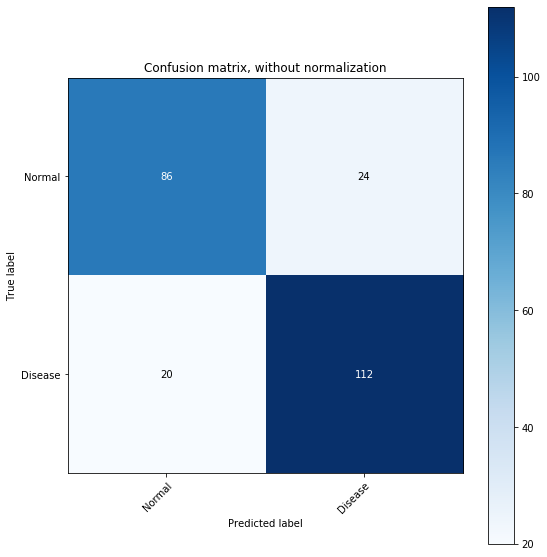

In [171]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

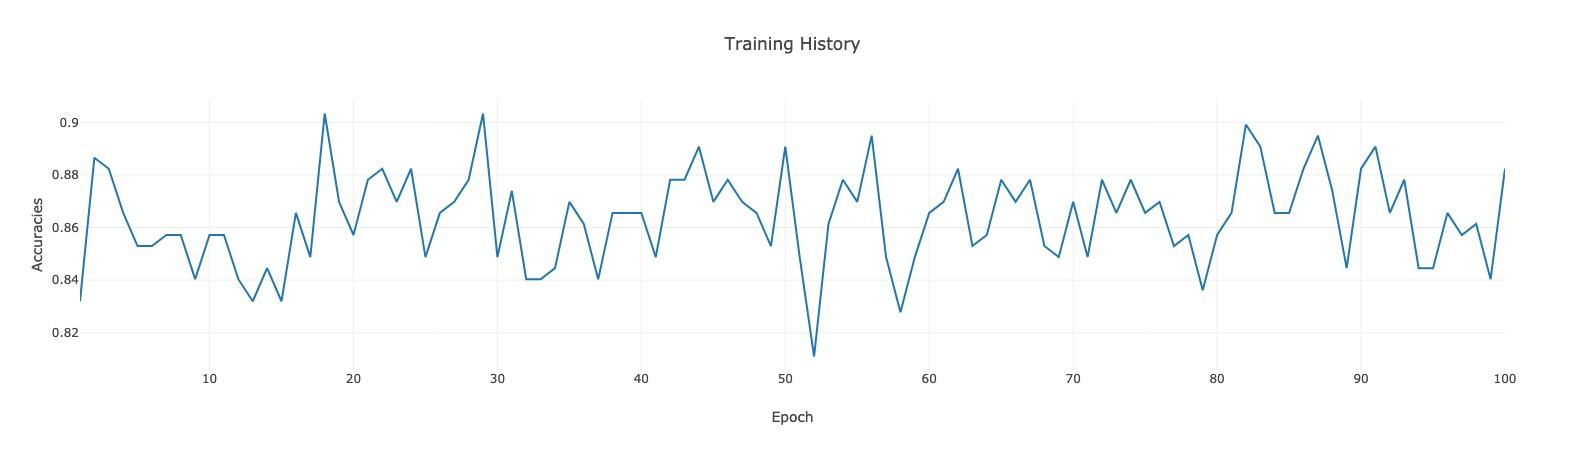

In [204]:
from plotly.offline import iplot
from plotly.offline import plot

accs = nn.history.history["acc"]
loss = nn.history.history["loss"]

accs_plot = go.Scatter(
    x=[x for x in range(1,len(accs)+1)],
    y=accs,
    mode="lines",
    name="line plot"
)

data = [accs_plot]

layout = go.Layout(
    title= "Training History",
    yaxis= {"title":"Accuracies"},
    xaxis={"title":"Epoch"}
)

fig = go.Figure(data=data, layout=layout)


iplot(fig)

In [176]:
min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(min_cluster_sizes=min_cluster_sizes, plot=False)

Minimum Size:
Clusters                  8
Noise                     3
Silhouette                5
Halkidi                   3
Halkidi-Filtered Noise    7
Halkidi-Bounded Noise     3
dtype: int64


,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
3,2,0.455357,4.066394e-02,9.217576e-01,1.497824e+00,1.701455e+00
4,2,0.562500,2.202793e-02,1.042626e+00,9.401677e-01,1.704960e+00
5,2,0.633929,-2.378437e-02,1.360350e+00,9.480454e-01,1.706872e+00
6,2,0.607143,-1.547038e-02,9.484465e-01,9.074776e-01,1.703943e+00
7,2,0.642857,-2.224568e-02,9.337048e-01,7.292980e-01,1.703943e+00
8,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
9,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
10,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
11,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
12,0,1.000000,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [177]:
pd.Series(pipeline.clusterer.labels_).value_counts()

-1    51
 1    50
 0    11
dtype: int64

In [178]:
samples, cluster_labels = pipeline.get_validation_clusters()

In [179]:
pd.Series(cluster_labels).value_counts()

-1    31
dtype: int64

## Plotting Testing LRP

In [182]:
from sklearn.preprocessing import MinMaxScaler
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class
split_class_lrp = np.array(pipeline.lrp_results)[split_class]

data = np.clip(split_class_lrp, 0,None)
sdata = MinMaxScaler().fit_transform(data)

In [194]:
labels = correct_pred_labels[split_class]
len(labels)

112

In [201]:
import umap
from matplotlib import pyplot as plt

reducer = umap.UMAP(random_state=42,
                    n_components = 2,
                    n_neighbors=7,
                    min_dist=0)
embedding = reducer.fit_transform(sdata)

emb2d = go.Scatter(
    x=embedding[:,0],
    y=embedding[:,1],
    mode="markers"
)

layout = go.Layout(
    title= "2D LRP Embedding"
)

data=[emb2d]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [207]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=7,
                    min_dist=0)
embedding = reducer.fit_transform(sdata)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

layout = go.Layout(
    title= "3D LRP Embedding"
)

data=[emb3d]

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='lrp-3d-scatter.html')

'lrp-3d-scatter.html'

## Plotting Validation LRP

In [265]:
val_target_class = pipeline.val_set.labels[pipeline.val_pred_mask] == pipeline.target_class

data = np.clip(pipeline.val_set_lrp, 0,None)
val_lrp = MinMaxScaler().fit_transform(data)

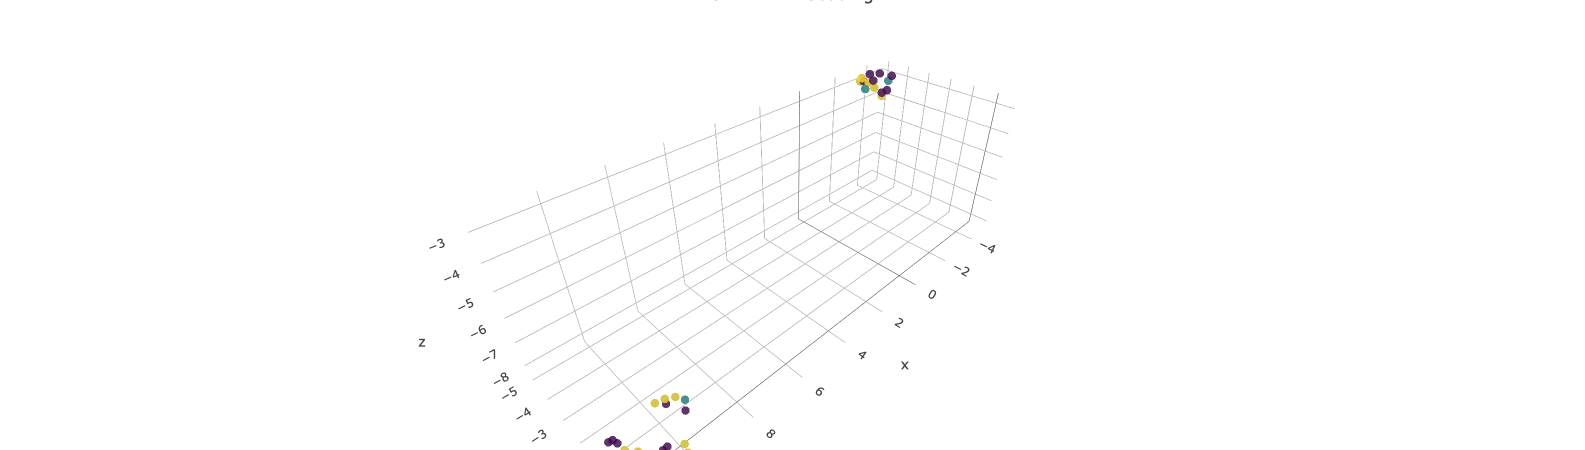

In [266]:
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=7,
                    min_dist=0)
embedding = reducer.fit_transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
#             width=0.5,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title= "3D LRP Embedding",
     margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-test.html')

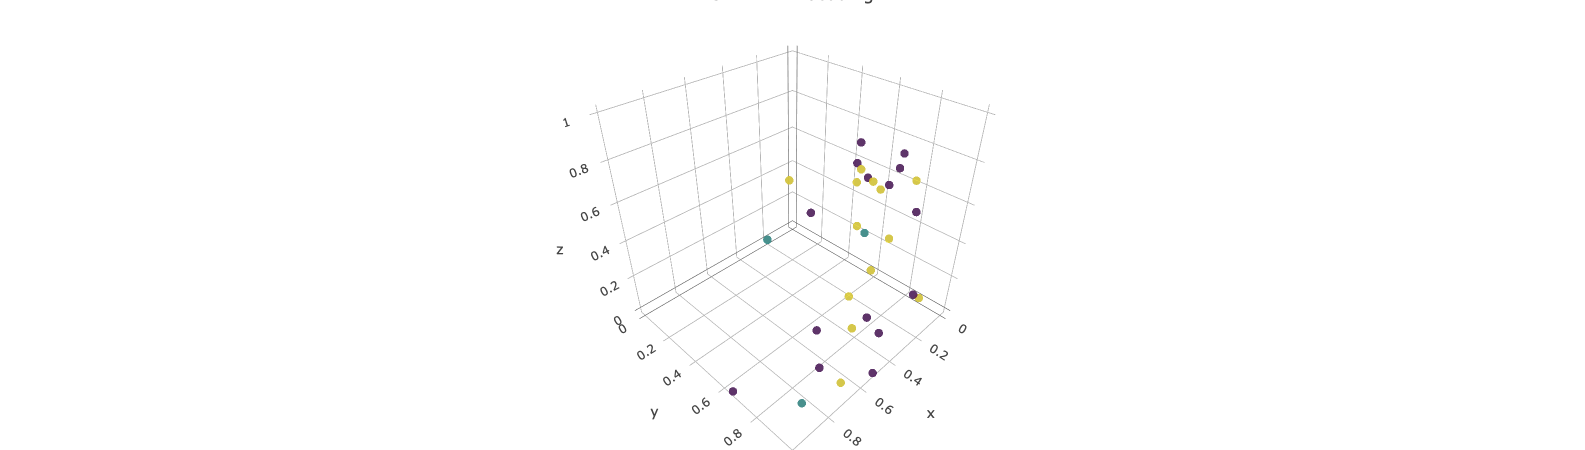

In [270]:
# reducer = umap.UMAP(random_state=42,
#                     n_components = 3,
#                     n_neighbors=7,
#                     min_dist=0)
# embedding = reducer.fit_transform(sdata)

val_emb3d = go.Scatter3d(
    x=val_lrp[:,2],
    y=val_lrp[:,3],
    z=val_lrp[:,6],
    mode="markers",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
#             width=0.5,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title= "3D LRP Embedding",margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-scatter.html')

In [225]:
pd.DataFrame(sdata)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.287109,0.712192,0.0,0.0,0.731190,0.696336,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.495828,0.822155,0.0,0.0,1.000000,0.253903,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.874045,0.0,0.0,0.000000,0.562659,0.0,0.066717,0.0,0.0,0.0
3,0.0,0.0,0.319745,0.800376,0.0,0.0,0.728736,0.777961,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.606823,0.950408,0.0,0.0,0.746275,0.659951,0.0,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.842809,0.894362,0.0,0.0,0.000000,0.739430,0.0,0.184801,0.0,0.0,0.0
6,0.0,0.0,0.686240,0.669700,0.0,0.0,0.868251,0.498763,0.0,0.100755,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.840938,0.0,0.0,0.000000,0.421558,0.0,0.201946,0.0,0.0,0.0
8,0.0,0.0,0.234121,0.624742,0.0,0.0,0.000000,0.275770,0.0,0.161108,0.0,0.0,0.0
9,0.0,0.0,0.657435,0.938177,0.0,0.0,0.000000,0.509168,0.0,1.000000,0.0,0.0,0.0


In [308]:
import hdbscan

data = np.clip(split_class_lrp, 0,None)
mmscaler =  MinMaxScaler().fit(data)
lrp_data = mmscaler.transform(data)

val_data = np.clip(pipeline.val_set_lrp, 0,None)
val_lrp = MinMaxScaler().fit_transform(val_data)

clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=1, prediction_data=True)
clusterer.fit(lrp_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=7, min_samples=1, p=None,
        prediction_data=True)

In [309]:
# lrp_data[:,[2,3,6,7,9]]

In [310]:
pd.Series(clusterer.labels_).value_counts()

 1    63
-1    34
 0    15
dtype: int64

In [311]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_lrp)
pd.Series(cluster_labels).value_counts()

-1    31
dtype: int64

In [297]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, prediction_data=True)
clusterer.fit(lrp_data[:,[2,3,6,7,9]])
pd.Series(clusterer.labels_).value_counts()

 1    83
-1    23
 0     6
dtype: int64

In [298]:
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, val_lrp[:,[2,3,6,7,9]])

In [299]:
pd.Series(cluster_labels).value_counts()

-1    30
 1     1
dtype: int64